### ESGF: Simple One Dataset Example 

This example goes through how to access data from Earth System Grid Federation (ESGF) and visualise data with simple plots.

**Packages:**

- matplotlib
- numpy
- pandas 
    - *tool for reading data*, *data analysis and manipulation*
- xarray 
    - *for handling of multidimensional arrays*
- zarr 
    - *format for the storage of chunked, compressed, multidimensional arrays*
- fsspec 
    - *for accessing data from Google Cloud Storage*
- pyesgf
    - *package for interacting with ESGF*

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#pyesgf is module in esgf-pyclient library, that is used to import search-functions
from pyesgf.search import SearchConnection

In [2]:
#creates new search connection and connects to esgf 
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)

In [3]:
#next we need to define what  we are searching
#(historical monthly near surface temperature from NCAR)
ctx = conn.new_context(
    activity_id= 'CMIP',
    institution_id= 'NCAR',
    experiment_id= 'historical',
    table_id='Amon',
    variable='tas',
    member_id='r11i1p1f1')

#hit count of this search
ctx.hit_count


-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


5

In [4]:
#execute the actual search
results = ctx.search()

#printing the dataset-id of all the results
for res in results:
    print(res.dataset_id)

CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.Amon.tas.gn.v20190514|aims3.llnl.gov
CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.Amon.tas.gn.v20190514|esgf-data.ucar.edu
CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.Amon.tas.gn.v20190514|esgf3.dkrz.de
CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.Amon.tas.gn.v20190514|esgf.ceda.ac.uk
CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.Amon.tas.gn.v20190514|esgf.nci.org.au


In [5]:
#some datasets are divided into multiple files
#we can do additional search to get the file context for specific dataset
files = results[0].file_context().search()

#pritnting how many files the first result contains
print(len(files))

#when planning to use whole data it might be useful to combine all of the files into one list
files_all = []
for file in files:
    files_all.append(file.opendap_url)


-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------


4


In [6]:
#xarray can be used to open the datasets

#if you only need single file and do not need the whole timeseries you can simply open one of the files 
ds_1 = xr.open_dataset(files[0].opendap_url, chunks={'time': 120})
print(ds_1) #gives you better idea what the dataset contains

#the same can be done with the combined list of files we created earlier
ds = xr.open_mfdataset(files_all, chunks={'time': 120}, combine='nested', concat_dim='time')

/home/koli/.local/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 600, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 1899-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0


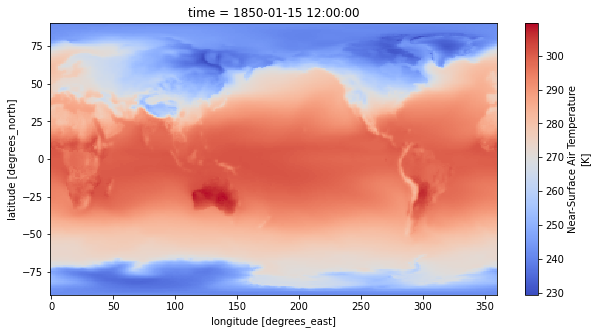

In [7]:
#selecting first point of time
data = ds.tas.isel(time=0)
#plotting as coolwarm colormap
data.squeeze().plot(aspect=2, size=5, cmap=plt.cm.coolwarm)

In [8]:
#temperature data in celsisus degrees
tas = ds.tas - 273.15

In [9]:
#creating weights to weight data according to area
weights = np.cos(np.deg2rad(tas.lat))
weights.name = "weights"

In [10]:
#calculating weighted global means
tas_weighted = tas.weighted(weights)
weighted_mean = tas_weighted.mean(("lon", "lat"))

In [11]:
%time weighted_mean.load()

CPU times: user 12 s, sys: 6.52 s, total: 18.6 s
Wall time: 3min 32s


<xarray.DataArray 'tas' (time: 1980)>
array([12.19457634, 12.36577744, 13.07857409, ..., 15.31395323,
       14.57309192, 13.90635785])
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

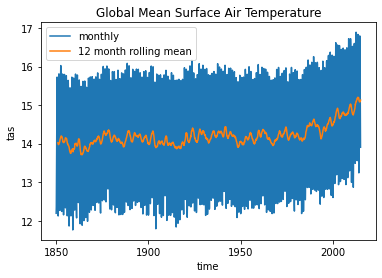

In [12]:
#plotting the weighted global mean and its rolling mean
weighted_mean.plot(label='monthly')
weighted_mean.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.title('Global Mean Surface Air Temperature')
plt.legend()
plt.show()